In [11]:
import numpy as np
import pickle
from joblib import Parallel, delayed
from scipy import stats
from pyvbmc import VBMC
import corner


from psiam_delay_paper_utils import abort_RT_loglike_fn, correct_RT_loglike_fn, wrong_RT_loglike_fn

In [3]:
with open('psiam_data_delay_paper_1.pkl', 'rb') as f:
    psiam_data = pickle.load(f)


choices = psiam_data['choices']
RTs = psiam_data['RTs']
is_act_resp = psiam_data['is_act_resp']
V_A = psiam_data['V_A']
theta_A = psiam_data['theta_A']
V_E = psiam_data['V_E']
theta_E = psiam_data['theta_E']
Z_E = psiam_data['Z_E']
t_stim = psiam_data['t_stim']
t_A_aff = psiam_data['t_A_aff']
t_E_aff = psiam_data['t_E_aff']
t_motor = psiam_data['t_motor']


indices_evid = np.where(is_act_resp == 0)[0]
RTs_evid = RTs[indices_evid].flatten()

indices_act = np.where(is_act_resp == 1)[0]
RTs_act = RTs[indices_act].flatten()

RTs = RTs.flatten()


correct_idx = np.where(choices == 1)[0]
wrong_idx = np.where(choices == -1)[0]
non_abort_idx = np.where(RTs >= t_stim)[0]

correct_non_abort_idx = np.intersect1d(correct_idx, non_abort_idx)
wrong_non_abort_idx = np.intersect1d(wrong_idx, non_abort_idx)

correct_RT = RTs[correct_non_abort_idx]
wrong_RT = RTs[wrong_non_abort_idx]

abort_idx = np.where(RTs < t_stim)[0]
abort_RT = RTs[abort_idx]


print(f"V_A: {V_A}")
print(f"theta_A: {theta_A}")
print(f"V_E: {V_E}")
print(f"theta_E: {theta_E}")
print(f"t stim is {t_stim}")
print(f"t_A_aff: {t_A_aff}, t_E_aff: {t_E_aff}, t_motor: {t_motor}")

print(f"Num of AI process: {is_act_resp.sum()}/{len(is_act_resp)}")
print(f'Number of aborts = {(RTs < t_stim).sum()}')



V_A: 1
theta_A: 2
V_E: 1.2
theta_E: 2
t stim is 0.5
t_A_aff: 0.02, t_E_aff: 0.03, t_motor: 0.05
Num of AI process: 5925/10000
Number of aborts = 124


In [6]:
def psiam_loglike_fn(params):
    V_A, theta_A, V_E, theta_E, Z_E, t_A_aff, t_E_aff, t_motor = params

    K_max = int(10)
    n_jobs = -1

    abort_loglike = sum(Parallel(n_jobs=n_jobs)(delayed(abort_RT_loglike_fn)(t, V_A, theta_A, V_E, theta_E, Z_E, K_max, t_A_aff, t_E_aff, t_stim, t_motor) for t in abort_RT))
    correct_loglike = sum(Parallel(n_jobs=n_jobs)(delayed(correct_RT_loglike_fn)(t, V_A, theta_A, V_E, theta_E, Z_E, K_max, t_A_aff, t_E_aff, t_stim, t_motor) for t in correct_RT))
    wrong_loglike = sum(Parallel(n_jobs=n_jobs)(delayed(wrong_RT_loglike_fn)(t, V_A, theta_A, V_E, theta_E, Z_E, K_max, t_A_aff, t_E_aff, t_stim, t_motor) for t in wrong_RT))


    loglike = abort_loglike + correct_loglike + wrong_loglike

    if np.isnan(loglike):
        raise ValueError('loglike is nan')
    if np.isinf(loglike):
        raise ValueError('loglike is inf')
    
    return loglike
    

In [24]:
#  V_A=1, theta_A=2, V_E=1.2, theta_E=2, Z_E=0, 
# t_A_aff=0.02, t_E_aff=0.03, t_motor=0.05

V_A_bounds = [0.1, 2]; V_A_plausible_bounds = [0.5, 1.5]
theta_A_bounds = [1, 3]; theta_A_plausible_bounds = [1.5, 2.5]
V_E_bounds = [-2, 2]; V_E_plausible_bounds = [-1.5, 1.5]
theta_E_bounds = [0.1, 3]; theta_E_plausible_bounds = [0.5,2.5]
Z_E_bounds = [-0.5, 0.5]; Z_E_plausible_bounds = [-0.2, 0.2]
t_A_aff_bounds = [0.01, 0.06]; t_A_aff_plausible_bounds = [0.015, 0.05]
t_E_aff_bounds = [0.01, 0.06]; t_E_aff_plausible_bounds = [0.02, 0.05]
t_motor_bounds = [0.01, 0.06]; t_motor_plausible_bounds = [0.03, 0.06]


def psiam_log_prior_fn(params):
    V_A, theta_A, V_E, theta_E, Z_E, t_A_aff, t_E_aff, t_motor = params
    

    # declare distributions
    V_A_prior = stats.uniform(loc=V_A_bounds[0], scale=V_A_bounds[1] - V_A_bounds[0])
    theta_A_prior = stats.uniform(loc=theta_A_bounds[0], scale=theta_A_bounds[1] - theta_A_bounds[0])
    V_E_prior = stats.uniform(loc=V_E_bounds[0], scale=V_E_bounds[1] - V_E_bounds[0])
    theta_E_prior = stats.uniform(loc=theta_E_bounds[0], scale=theta_E_bounds[1] - theta_E_bounds[0])
    Z_E_prior = stats.uniform(loc=Z_E_bounds[0], scale=Z_E_bounds[1] - Z_E_bounds[0])
    t_A_aff_prior = stats.uniform(loc=t_A_aff_bounds[0], scale=t_A_aff_bounds[1] - t_A_aff_bounds[0])
    t_E_aff_prior = stats.uniform(loc=t_E_aff_bounds[0], scale=t_E_aff_bounds[1] - t_E_aff_bounds[0])
    t_motor_prior = stats.uniform(loc=t_motor_bounds[0], scale=t_motor_bounds[1] - t_motor_bounds[0])


    # PDF
    log_prior_V_A = V_A_prior.logpdf(V_A)
    log_prior_theta_A = theta_A_prior.logpdf(theta_A)
    log_prior_V_E = V_E_prior.logpdf(V_E)
    log_prior_theta_E = theta_E_prior.logpdf(theta_E)
    log_prior_Z_E = Z_E_prior.logpdf(Z_E)
    log_prior_t_A_aff = t_A_aff_prior.logpdf(t_A_aff)
    log_prior_t_E_aff = t_E_aff_prior.logpdf(t_E_aff)
    log_prior_t_motor = t_motor_prior.logpdf(t_motor)

    sum_log_priors = log_prior_V_A + log_prior_theta_A + log_prior_V_E + log_prior_theta_E + log_prior_Z_E + log_prior_t_A_aff + log_prior_t_E_aff + log_prior_t_motor
    return sum_log_priors

def log_joint(params):
    loglike = psiam_loglike_fn(params)
    logprior = psiam_log_prior_fn(params)
    prior_plus_loglike = loglike + logprior
    return prior_plus_loglike

In [25]:
lb = np.array([V_A_bounds[0], theta_A_bounds[0], V_E_bounds[0], theta_E_bounds[0], Z_E_bounds[0], 
               t_A_aff_bounds[0], t_E_aff_bounds[0], t_motor_bounds[0]])
ub = np.array([V_A_bounds[1], theta_A_bounds[1], V_E_bounds[1], theta_E_bounds[1], Z_E_bounds[1], 
               t_A_aff_bounds[1], t_E_aff_bounds[1], t_motor_bounds[1]])
plb = np.array([V_A_plausible_bounds[0], theta_A_plausible_bounds[0], V_E_plausible_bounds[0], theta_E_plausible_bounds[0], Z_E_plausible_bounds[0], 
                t_A_aff_plausible_bounds[0], t_E_aff_plausible_bounds[0], t_motor_plausible_bounds[0]])
pub = np.array([V_A_plausible_bounds[1], theta_A_plausible_bounds[1], V_E_plausible_bounds[1], theta_E_plausible_bounds[1], Z_E_plausible_bounds[1], 
                t_A_aff_plausible_bounds[1], t_E_aff_plausible_bounds[1], t_motor_plausible_bounds[1]])

np.random.seed(42)  
V_A_0 = np.random.uniform(plb[0], pub[0])
theta_A_0 =  np.random.uniform(plb[1], pub[1])
V_E_0 = np.random.uniform(plb[2], pub[2])
theta_E_0 = np.random.uniform(plb[3], pub[3])
Z_0 = np.random.uniform(plb[4], pub[4])
t_A_aff_0 = np.random.uniform(plb[5], pub[5])
t_E_aff_0 = np.random.uniform(plb[6], pub[6])
t_motor_0 = np.random.uniform(plb[7], pub[7])

x0 = np.array([V_A_0, theta_A_0, V_E_0, theta_E_0, Z_0, t_A_aff_0, t_E_aff_0, t_motor_0]);

vbmc = VBMC(log_joint, x0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 8).
Reshaping upper bounds to (1, 8).
Reshaping plausible lower bounds to (1, 8).
Reshaping plausible upper bounds to (1, 8).
vbmc:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.


/home/rka/.local/lib/python3.10/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/home/rka/.local/lib/python3.10/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/home/rka/.local/lib/python3.10/site-packages/cma/evolution_strategy.py:3823: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)
/home/rka/.local/lib/python3.10/site-packages/cma/evolution_strategy.py:3824: RuntimeWarning: invalid value encountered in scalar subtract
  historic_fitness_range = max(es.fit.hist) - min(es.fit.hist)
/home/rka/.local/lib/python3.10/site-packages/pyvbmc/whitening/whitening.py:341: RuntimeWarning: divide by zero encountered in log
  ] = np.log(omegaw).T

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -12381.638 +/-0.023.


Too few points to create valid contours


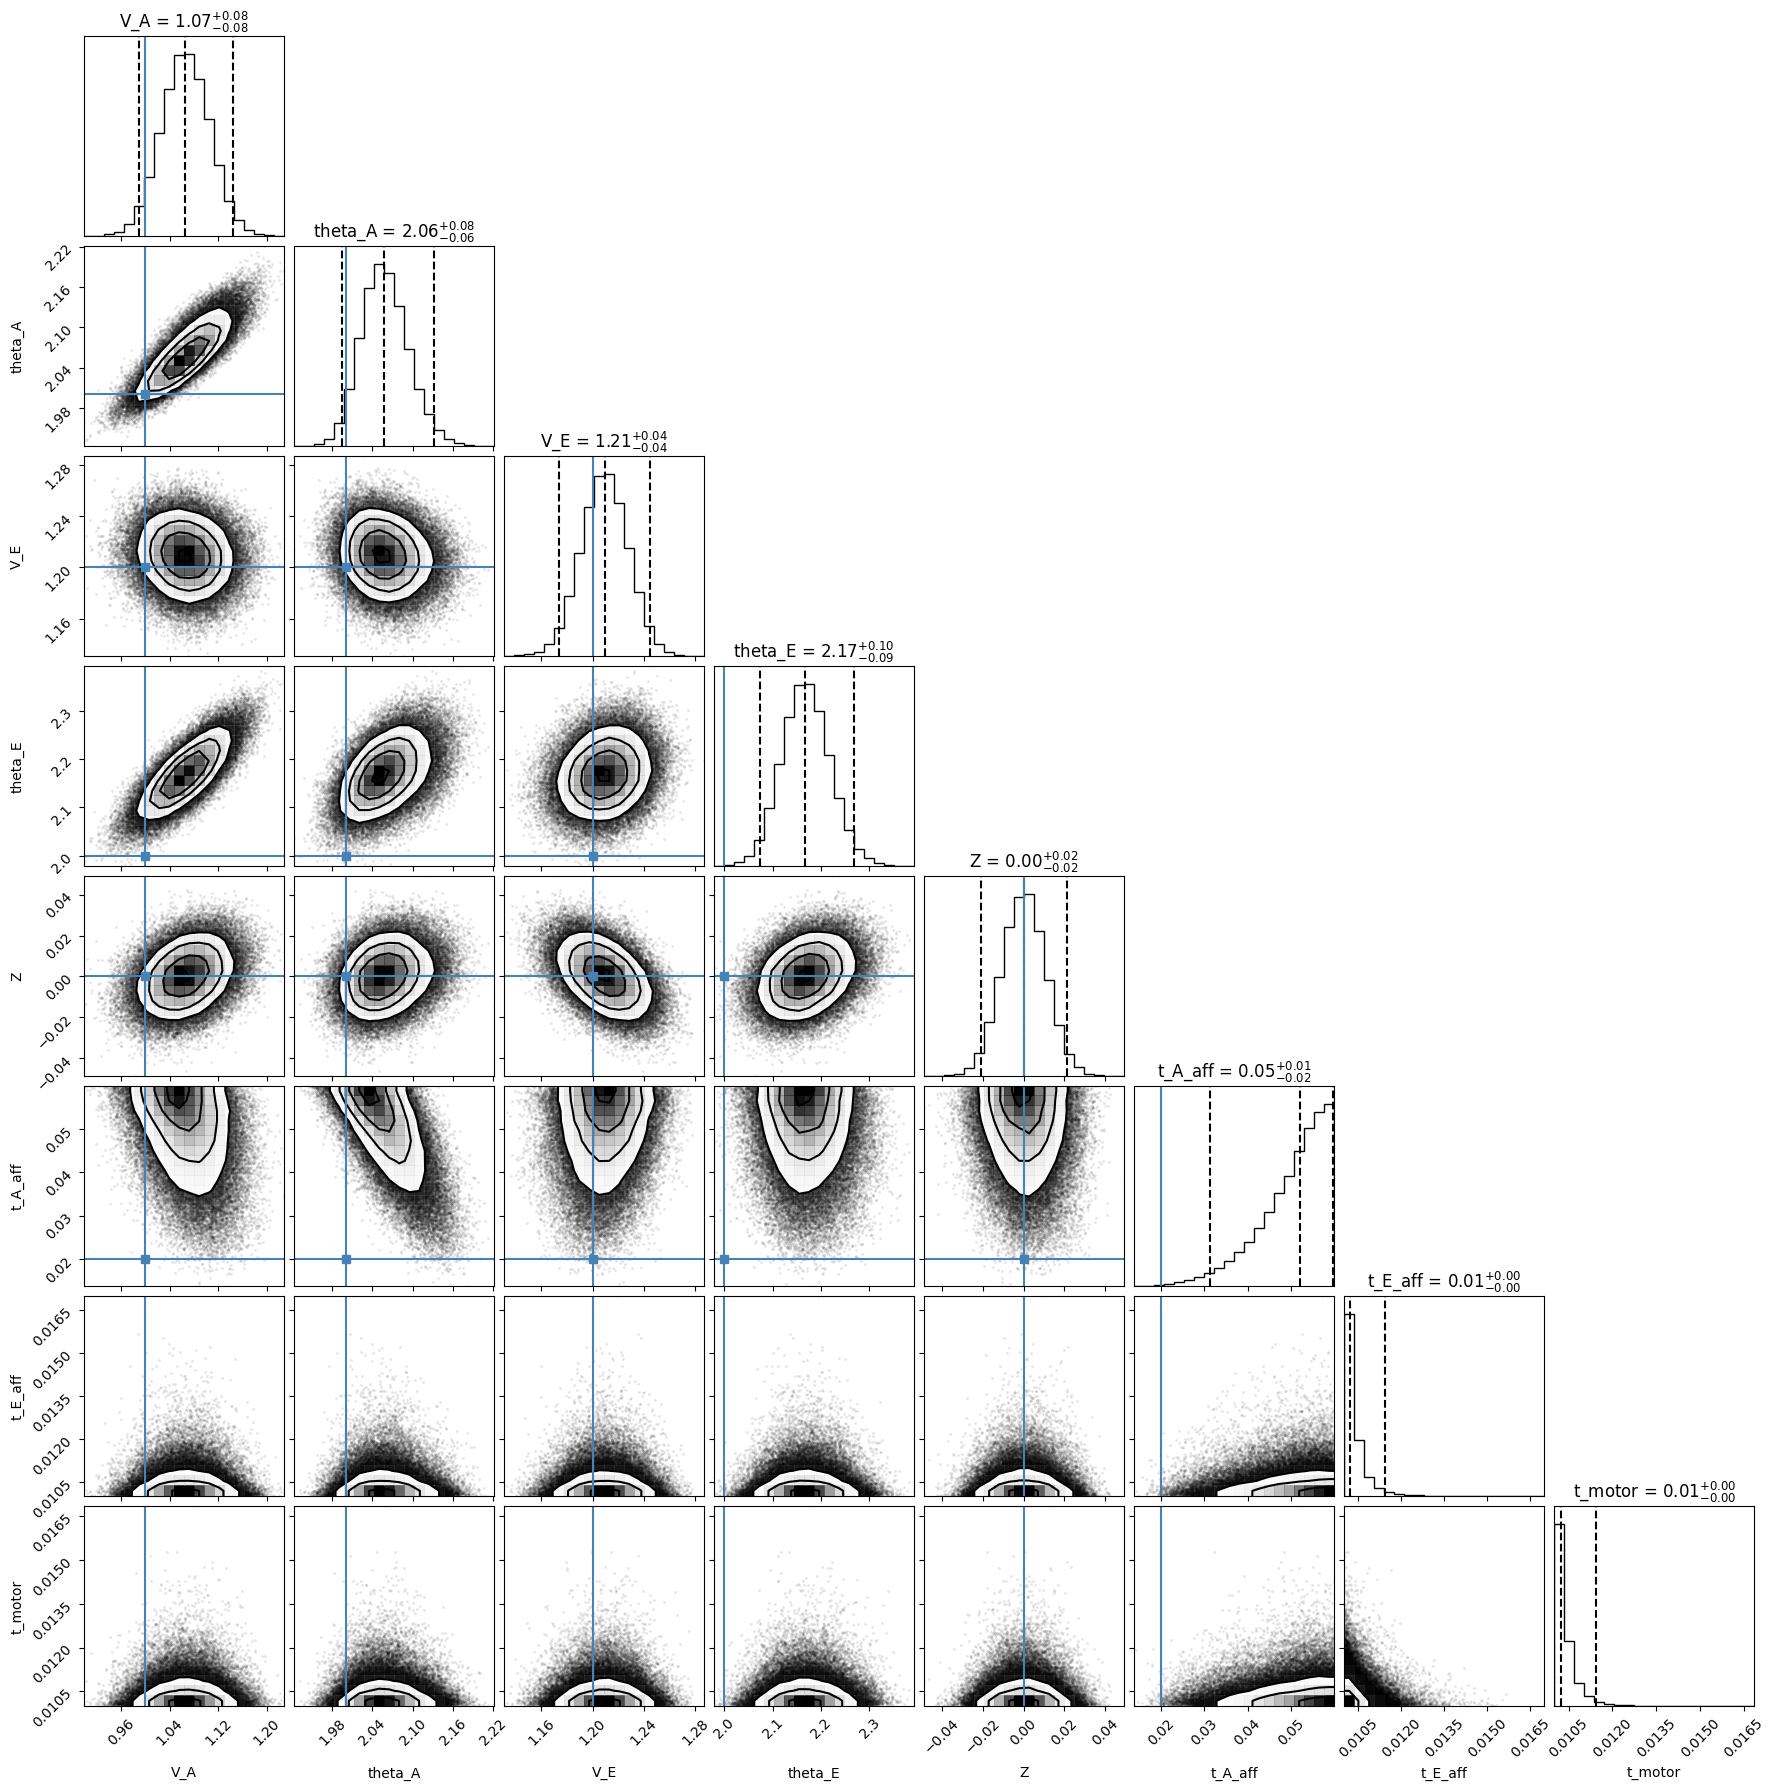

In [26]:
vp_samples = vp.sample(int(1e5))[0]
V_A_samp = vp_samples[:,0]; theta_A_samp = vp_samples[:,1]
V_E_samp = vp_samples[:,2]; theta_E_samp = vp_samples[:,3]
Z_samp =  vp_samples[:,4]
t_A_aff_samp = vp_samples[:,5]; t_E_aff_samp = vp_samples[:,6]; t_motor_samp = vp_samples[:,7]

combined_samples_vb = np.transpose(np.vstack((V_A_samp, theta_A_samp, V_E_samp, theta_E_samp, Z_samp, t_A_aff_samp, t_E_aff_samp, t_motor_samp)))
params_labels = ['V_A', 'theta_A', 'V_E', 'theta_E', 'Z', 't_A_aff', 't_E_aff', 't_motor']
true_arr = [V_A, theta_A, V_E, theta_E, Z_E, t_A_aff, t_E_aff, t_motor]

corner.corner(combined_samples_vb, labels=params_labels, show_titles=True, quantiles=[0.025, 0.5, 0.975], truths=true_arr); # range=corner_span
